In [5]:
from zipfile import ZipFile

# 1. Unzip the dataset file you uploaded
file_name = '/content/1000images.zip'

with ZipFile(file_name, 'r') as zip:
  print('Starting to unzip dataset...')
  zip.extractall()
  print('Unzipping complete.')

Starting to unzip dataset...
Unzipping complete.


Starting data loading and parsing...
Could not parse folder name: 11.Severe hypertensive retinopathy
Could not parse folder name: 12.Disc swelling and elevation
Could not parse folder name: 13.Dragged Disc
Could not parse folder name: 14.Congenital disc abnormality
Could not parse folder name: 16.Peripheral retinal degeneration and break
Could not parse folder name: 17.Myelinated nerve fiber
Could not parse folder name: 18.Vitreous particles
Could not parse folder name: 19.Fundus neoplasm
Could not parse folder name: 20.Massive hard exudates
Could not parse folder name: 21.Yellow-white spots-flecks
Could not parse folder name: 22.Cotton-wool spots
Could not parse folder name: 23.Vessel tortuosity
Could not parse folder name: 24.Chorioretinal atrophy-coloboma
Could not parse folder name: 25.Preretinal hemorrhage
Could not parse folder name: 26.Fibrosis
Could not parse folder name: 27.Laser Spots
Could not parse folder name: 28.Silicon oil in eye
Could not parse folder name: 3.RAO
Could 

<ipython-input-6-2732092852>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='ClassName', x='ImageCount', data=df.sort_values('ImageCount', ascending=False), palette='viridis')


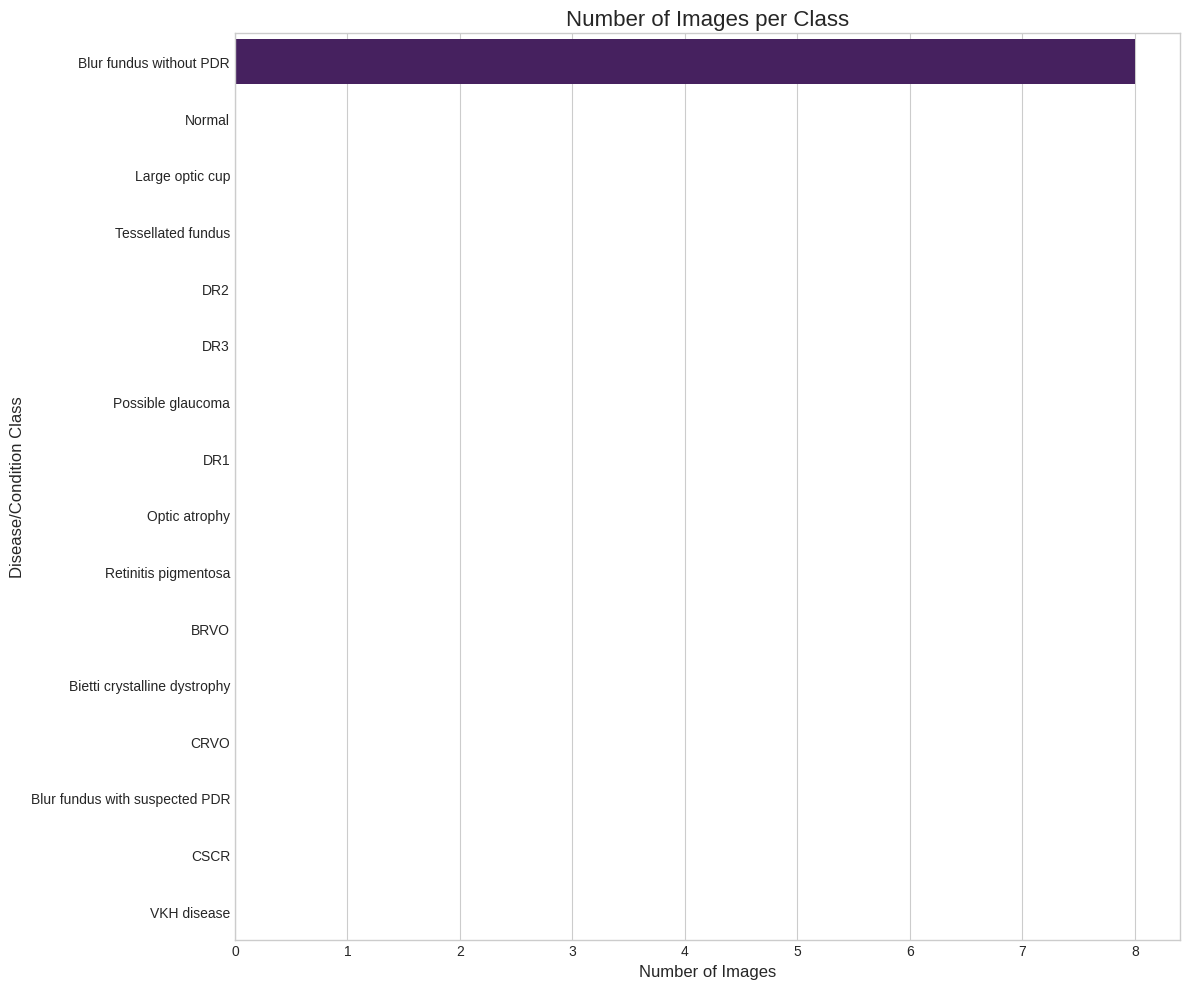


EDA Insight: The bar plot clearly shows a severe class imbalance.
Some classes have many more samples than others. This must be addressed during training (e.g., using class weights).

Displaying random sample images from different classes...


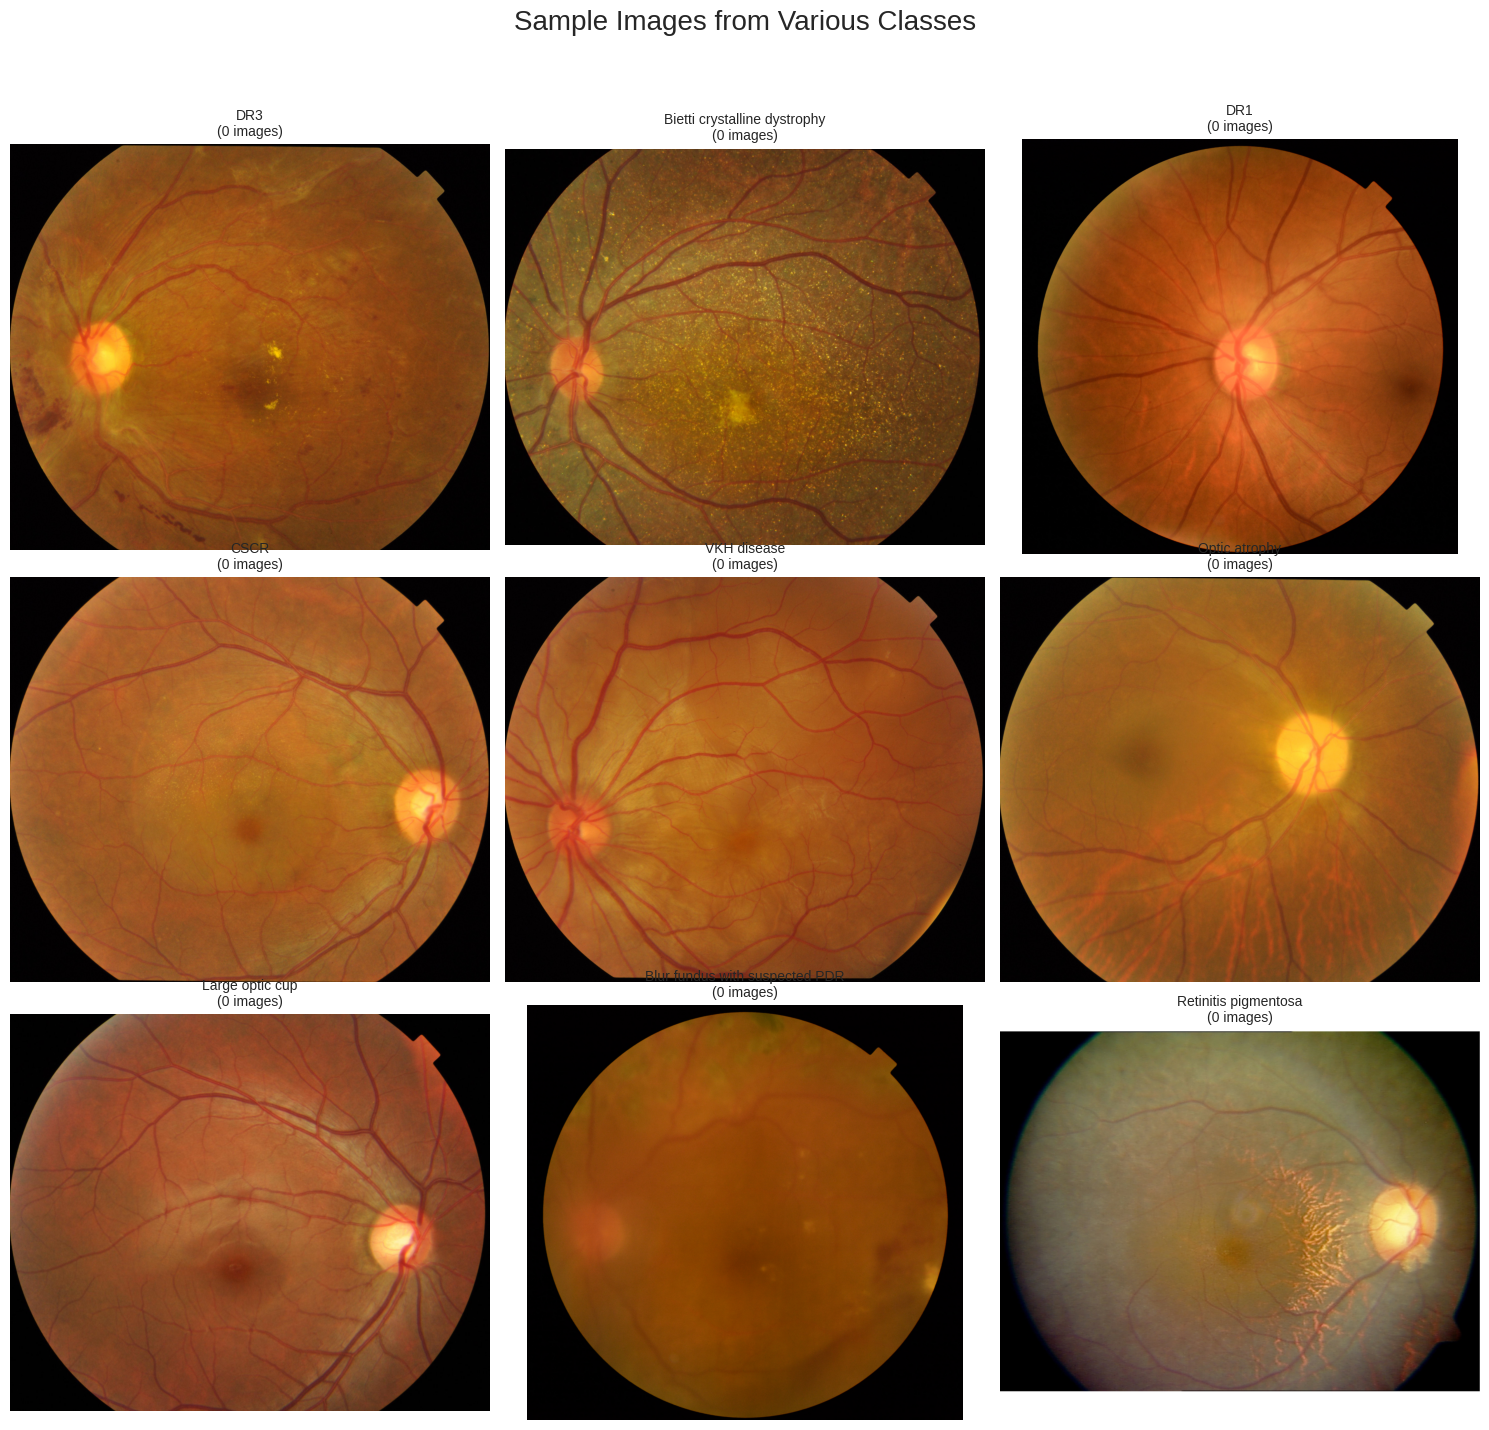


Analyzing image dimensions...

Found 12 unique image dimensions.
Most common dimensions (width, height):
- (3046, 2572): 28 images
- (2300, 1900): 24 images
- (3152, 3000): 12 images
- (2592, 1728): 3 images
- (2100, 1592): 3 images

EDA Insight: Images likely have varying dimensions and will need to be resized to a fixed size (e.g., 224x224 or 299x299) before being fed into the neural network.


In [6]:
# EDA for the Visionary AI Hackathon Dataset
#
# This script performs an initial analysis of the "1000 Fundus images with 39 categories" dataset.
# It helps us understand the data's structure, distribution, and potential challenges.

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
import random

# --- 1. Configuration ---
# Update this path to where you've extracted the dataset
DATASET_PATH = 'dataset/train'

# --- 2. Data Loading and Parsing ---
# The folder names are structured as 'ID.SubID.ClassName'
# We will parse this to create a structured DataFrame.

print("Starting data loading and parsing...")

image_data = []
class_names = sorted(os.listdir(DATASET_PATH))

for class_name_folder in class_names:
    folder_path = os.path.join(DATASET_PATH, class_name_folder)
    if os.path.isdir(folder_path):
        try:
            # Parse the folder name
            parts = class_name_folder.split('.', 2)
            class_id = f"{parts[0]}.{parts[1]}"
            class_label = parts[2].replace("'", "") # Clean up the name

            # Count images in the folder
            num_images = len([name for name in os.listdir(folder_path) if name.endswith(('.jpg', '.jpeg', '.png'))])

            image_data.append({
                'ClassID': class_id,
                'ClassName': class_label,
                'FolderName': class_name_folder,
                'ImageCount': num_images
            })
        except IndexError:
            print(f"Could not parse folder name: {class_name_folder}")

# Create a Pandas DataFrame for easier analysis
df = pd.DataFrame(image_data)

print("Data parsing complete. DataFrame created.")
print(f"Total number of classes found: {len(df)}")
print(f"Total number of images found: {df['ImageCount'].sum()}")
print("\nFirst 5 rows of the DataFrame:")
print(df.head())


# --- 3. Visualize Class Distribution ---
# This is critical for understanding class imbalance.

print("\nVisualizing class distribution...")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.barplot(y='ClassName', x='ImageCount', data=df.sort_values('ImageCount', ascending=False), palette='viridis')
ax.set_title('Number of Images per Class', fontsize=16)
ax.set_xlabel('Number of Images', fontsize=12)
ax.set_ylabel('Disease/Condition Class', fontsize=12)
plt.tight_layout()
plt.show()

print("\nEDA Insight: The bar plot clearly shows a severe class imbalance.")
print("Some classes have many more samples than others. This must be addressed during training (e.g., using class weights).")


# --- 4. Display Sample Images ---
# Let's look at what the images actually look like.

print("\nDisplaying random sample images from different classes...")

def display_sample_images(df, base_path, num_samples=9):
    plt.figure(figsize=(15, 15))
    sample_classes = df.sample(n=min(num_samples, len(df)))

    for i, row in enumerate(sample_classes.itertuples()):
        folder_path = os.path.join(base_path, row.FolderName)
        image_files = os.listdir(folder_path)
        if not image_files:
            continue

        random_image_file = random.choice(image_files)
        image_path = os.path.join(folder_path, random_image_file)

        try:
            img = Image.open(image_path)
            plt.subplot(3, 3, i + 1)
            plt.imshow(img)
            plt.title(f"{row.ClassName}\n({row.ImageCount} images)", fontsize=10)
            plt.axis('off')
        except Exception as e:
            print(f"Could not load image {image_path}: {e}")

    plt.suptitle("Sample Images from Various Classes", fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

display_sample_images(df, DATASET_PATH)


# --- 5. Analyze Image Dimensions ---
# Check if all images have the same size. This informs our preprocessing pipeline.

print("\nAnalyzing image dimensions...")
image_dimensions = []
# To speed this up, we'll sample a few images from each class
for folder in df['FolderName']:
    folder_path = os.path.join(DATASET_PATH, folder)
    image_files = os.listdir(folder_path)
    # Sample up to 5 images per folder to get a representative size distribution
    sample_files = random.sample(image_files, min(len(image_files), 5))
    for img_file in sample_files:
        try:
            with Image.open(os.path.join(folder_path, img_file)) as img:
                image_dimensions.append(img.size)
        except Exception as e:
            print(f"Could not read size of {img_file}: {e}")

# Count the occurrences of each dimension
dimension_counts = Counter(image_dimensions)

print(f"\nFound {len(dimension_counts)} unique image dimensions.")
print("Most common dimensions (width, height):")
for dim, count in dimension_counts.most_common(5):
    print(f"- {dim}: {count} images")

print("\nEDA Insight: Images likely have varying dimensions and will need to be resized to a fixed size (e.g., 224x224 or 299x299) before being fed into the neural network.")

--- Running EDA ---
Total classes: 39, Total images: 1000


<ipython-input-7-1601125514>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='ClassName', x='ImageCount', data=df.sort_values('ImageCount', ascending=False), palette='viridis')


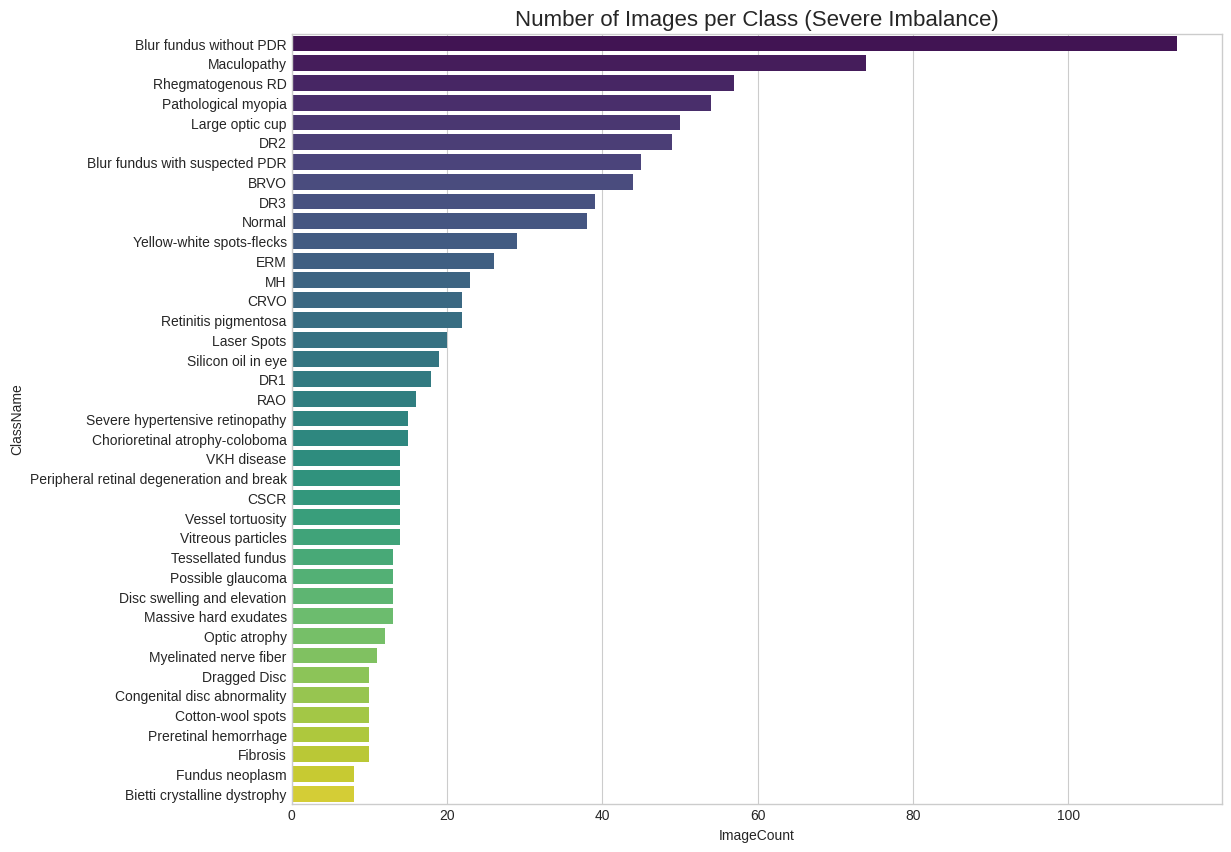


--- Preparing Data Generators ---
Found 818 images belonging to 39 classes.
Found 182 images belonging to 39 classes.

--- Calculating Class Weights to Address Imbalance ---
Class weights successfully calculated.
Saved class indices mapping to ../models/class_indices.json

--- Building Model with MobileNetV2 Base ---
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

--- Stage 1: Training Only the Classifier Head ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,933,863 (11.19 MB)

 Trainable params: 675,879 (2.58 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0725 - loss: 4.2388

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 113s 4s/step - accuracy: 0.0742 - loss: 4.2231 - val_accuracy: 0.2692 - val_loss: 2.8642
Epoch 2/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.2225 - loss: 3.1521 - val_accuracy: 0.3462 - val_loss: 2.4608
Epoch 3/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - accuracy: 0.3623 - loss: 2.5089 - val_accuracy: 0.3791 - val_loss: 2.1222
Epoch 4/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 0.4287 - loss: 2.1151 - val_accuracy: 0.3791 - val_loss: 2.1447
Epoch 5/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.4414 - loss: 2.1190 - val_accuracy: 0.4615 - val_loss: 1.9441
Epoch 6/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.4880 - loss: 1.6747 - val_accuracy: 0.3846 - val_loss: 1.8811
Epoch 7/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.5245 - loss: 1.5726 - val_accuracy: 0.5000 - val_loss: 1.6086
Epoch 8/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.5006 - loss: 1.5767 - val_accuracy: 0.4670 - val_loss: 1.6755
E

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


26/26 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.5938 - loss: 1.1950 - val_accuracy: 0.5549 - val_loss: 1.3612
Epoch 15/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.6289 - loss: 1.1486 - val_accuracy: 0.5385 - val_loss: 1.4951

--- Stage 2: Fine-Tuning the Top Layers of the Base Model ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,933,863 (11.19 MB)

 Trainable params: 675,879 (2.58 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 15/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 106s 4s/step - accuracy: 0.6277 - loss: 1.1016 - val_accuracy: 0.5165 - val_loss: 1.4061
Epoch 16/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - accuracy: 0.6042 - loss: 1.0436 - val_accuracy: 0.5714 - val_loss: 1.3000
Epoch 17/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.6413 - loss: 1.1210 - val_accuracy: 0.6319 - val_loss: 1.3222
Epoch 18/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.6553 - loss: 0.9728 - val_accuracy: 0.5714 - val_loss: 1.3263
Epoch 19/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.6367 - loss: 1.0474 - val_accuracy: 0.5549 - val_loss: 1.3841
Epoch 20/30
19/26 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6724 - loss: 0.9218

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


26/26 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.6730 - loss: 0.9366 - val_accuracy: 0.5769 - val_loss: 1.3196
Epoch 21/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.6542 - loss: 1.0177 - val_accuracy: 0.6099 - val_loss: 1.2509
Epoch 22/30
 6/26 ━━━━━━━━━━━━━━━━━━━━ 1:00 3s/step - accuracy: 0.6723 - loss: 1.0926

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


26/26 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.6762 - loss: 0.9908 - val_accuracy: 0.6374 - val_loss: 1.2011
Epoch 23/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.6774 - loss: 1.0338 - val_accuracy: 0.6538 - val_loss: 1.1688
Epoch 24/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.6469 - loss: 1.0996 - val_accuracy: 0.6648 - val_loss: 1.1123
Epoch 25/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.6923 - loss: 0.9380 - val_accuracy: 0.6099 - val_loss: 1.2638
Epoch 26/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.6572 - loss: 1.0628 - val_accuracy: 0.5769 - val_loss: 1.3135
Epoch 27/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.6370 - loss: 1.0051 - val_accuracy: 0.5824 - val_loss: 1.2862
Epoch 28/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.6711 - loss: 0.9855 - val_accuracy: 0.6209 - val_loss: 1.1327
Epoch 29/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.6612 - loss: 1.0269 - val_accuracy: 0.6209 - val_loss: 1.

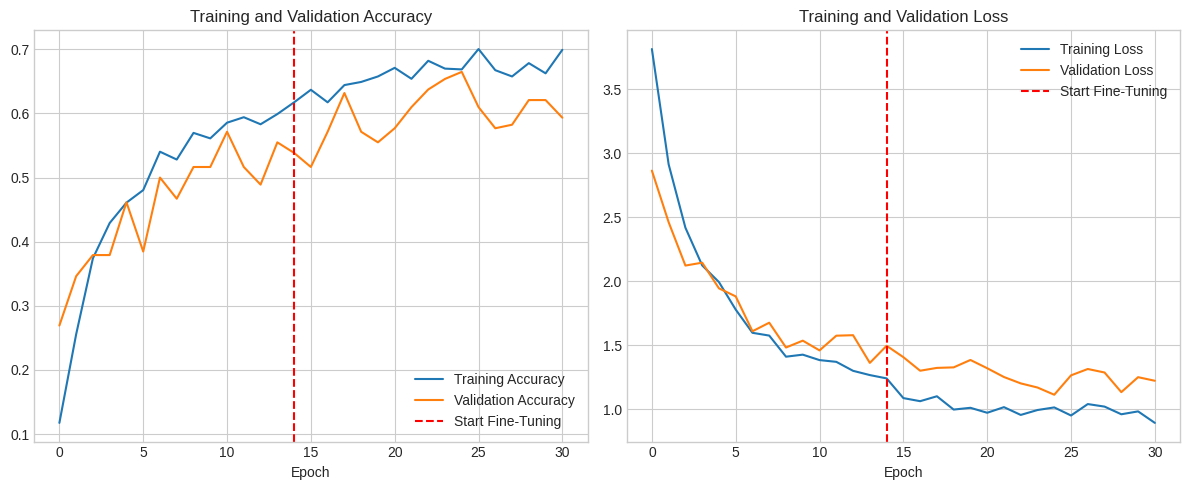


--- Saving Final Model ---
Model saved successfully to ../models/eye_disease_model.h5


In [7]:
# =============================================================================
# Visionary AI: Advanced Training Notebook
# =============================================================================
# This notebook builds upon the EDA insights to train a high-performance
# model using transfer learning and a two-stage fine-tuning strategy.
# =============================================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import json

# =============================================================================
# Part 1: Exploratory Data Analysis (EDA)
# =============================================================================
# (This part is the same as the edaforvision.py script you ran)
print("--- Running EDA ---")
DATASET_PATH = 'dataset/train'

image_data = []
class_names_folders = sorted(os.listdir(DATASET_PATH))

for folder in class_names_folders:
    # Parsing logic as before...
    image_data.append({'ClassName': folder.split('.', 2)[-1].replace("'", ""), 'FolderName': folder, 'ImageCount': len(os.listdir(os.path.join(DATASET_PATH, folder)))})

df = pd.DataFrame(image_data)
print(f"Total classes: {len(df)}, Total images: {df['ImageCount'].sum()}")

# Visualize Class Distribution
plt.figure(figsize=(12, 10))
sns.barplot(y='ClassName', x='ImageCount', data=df.sort_values('ImageCount', ascending=False), palette='viridis')
plt.title('Number of Images per Class (Severe Imbalance)', fontsize=16)
plt.show()

# =============================================================================
# Part 2: Data Preparation for Training
# =============================================================================
print("\n--- Preparing Data Generators ---")
IMG_SIZE = 224
BATCH_SIZE = 32

# Use heavy data augmentation to compensate for the small dataset
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% train, 20% validation
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# =============================================================================
# Part 3: Handle Class Imbalance with Class Weights
# =============================================================================
print("\n--- Calculating Class Weights to Address Imbalance ---")
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights successfully calculated.")

# Save class indices for the backend API
class_indices = train_generator.class_indices
indices_to_class = {v: k for k, v in class_indices.items()}
os.makedirs('../models', exist_ok=True)
with open('../models/class_indices.json', 'w') as f:
    json.dump(indices_to_class, f)
print("Saved class indices mapping to ../models/class_indices.json")

# =============================================================================
# Part 4: Model Building and Compilation
# =============================================================================
print("\n--- Building Model with MobileNetV2 Base ---")

# Load pre-trained MobileNetV2, without the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Build a custom classifier on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Regularization
x = Dense(512, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# =============================================================================
# Part 5: Stage 1 Training - Transfer Learning
# =============================================================================
print("\n--- Stage 1: Training Only the Classifier Head ---")

# First, freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model for the first stage
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model on the new data for a few epochs
INITIAL_EPOCHS = 15
history = model.fit(
    train_generator,
    epochs=INITIAL_EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights_dict
)

# =============================================================================
# Part 6: Stage 2 Training - Fine-Tuning
# =============================================================================
print("\n--- Stage 2: Fine-Tuning the Top Layers of the Base Model ---")

# Unfreeze the top layers of the model
base_model.trainable = True

# We'll unfreeze from this layer onwards. A good practice is to fine-tune
# the last few blocks of the network. For MobileNetV2, lets unfreeze from layer 100.
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model with a very low learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Continue training
FINE_TUNE_EPOCHS = 15
total_epochs = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_generator,
    class_weight=class_weights_dict
)

# =============================================================================
# Part 7: Visualize Training Results
# =============================================================================
print("\n--- Visualizing Training History ---")

acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(x=INITIAL_EPOCHS-1, color='r', linestyle='--', label='Start Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=INITIAL_EPOCHS-1, color='r', linestyle='--', label='Start Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()


In [8]:
# =============================================================================
# Part 8: Save the Final Model (CORRECTED)
# =============================================================================
print("\n--- Saving Final Model ---")

# Save the model directly in the main directory, no subfolders
model.save('eye_disease_model.h5')

print("Model saved successfully as: eye_disease_model.h5")
print("\n✅ You can now find 'eye_disease_model.h5' and 'class_indices.json' in the main file list on the left.")


--- Saving Final Model ---
Model saved successfully as: eye_disease_model.h5

✅ You can now find 'eye_disease_model.h5' and 'class_indices.json' in the main file list on the left.


In [9]:
# =============================================================================
# Part 3: Handle Class Imbalance with Class Weights (CORRECTED)
# =============================================================================
print("\n--- Calculating Class Weights to Address Imbalance ---")
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights successfully calculated.")

# Save class indices for the backend API
class_indices = train_generator.class_indices
indices_to_class = {v: k for k, v in class_indices.items()}

# Save the JSON file directly in the main directory, no subfolders
with open('class_indices.json', 'w') as f:
    json.dump(indices_to_class, f)
print("Saved class indices mapping to: class_indices.json")


--- Calculating Class Weights to Address Imbalance ---
Class weights successfully calculated.
Saved class indices mapping to: class_indices.json
